In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
import seaborn as sns
import itertools
a
# Hyperparameters
batch_size = 128
epochs = 30            # increase to improve performance
learning_rate = 1e-3
latent_dim = 2         # set to 2 for visualization; try 16 or 32 for better generation
random_seed = 42

tf.random.set_seed(random_seed)
np.random.seed(random_seed)

In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
# Normalize and reshape
image_shape = (28, 28, 1)
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0
x_train = np.reshape(x_train, (-1, 28, 28, 1))
x_test = np.reshape(x_test, (-1, 28, 28, 1))

In [ ]:
class Sampling(layers.Layer):
    """Use (z_mean, z_log_var) to sample z, the latent vector."""
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

def build_encoder(latent_dim=2):
    encoder_inputs = keras.Input(shape=image_shape)
    x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
    x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation="relu")(x)
    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    z = Sampling()([z_mean, z_log_var])
    encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
    return encoder

def build_decoder(latent_dim=2):
    latent_inputs = keras.Input(shape=(latent_dim,))
    x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
    x = layers.Reshape((7, 7, 64))(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
    decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
    decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
    return decoder

# Build models
encoder = build_encoder(latent_dim=latent_dim)
decoder = build_decoder(latent_dim=latent_dim)


In [ ]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, recon_loss_factor=1.0, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.recon_loss_factor = recon_loss_factor
        self.total_loss_tracker = keras.metrics.Mean(name="loss")
        self.recon_loss_tracker = keras.metrics.Mean(name="recon_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [self.total_loss_tracker, self.recon_loss_tracker, self.kl_loss_tracker]

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        return reconstructed

    def train_step(self, data):
        if isinstance(data, tuple):
            x = data[0]
        else:
            x = data
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(x, training=True)
            reconstruction = self.decoder(z, training=True)
            # Use binary crossentropy per pixel for MNIST
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(x, reconstruction), axis=(1,2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = self.recon_loss_factor * reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.recon_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "recon_loss": self.recon_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

# Instantiate VAE
vae = VAE(encoder, decoder)
optimizer = keras.optimizers.Adam(learning_rate)
vae.compile(optimizer=optimizer, loss=keras.losses.MeanSquaredError())

In [ ]:
history = vae.fit(x_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, x_test))

Epoch 1/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 99s 211ms/step - kl_loss: 5.4977 - loss: 157.1461 - recon_loss: 151.6484 - val_kl_loss: 0.0000e+00 - val_loss: 0.0000e+00 - val_recon_loss: 0.0000e+00
Epoch 2/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 139s 205ms/step - kl_loss: 5.7456 - loss: 154.4164 - recon_loss: 148.6708 - val_kl_loss: 0.0000e+00 - val_loss: 0.0000e+00 - val_recon_loss: 0.0000e+00
Epoch 3/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 101s 215ms/step - kl_loss: 5.9081 - loss: 152.4788 - recon_loss: 146.5707 - val_kl_loss: 0.0000e+00 - val_loss: 0.0000e+00 - val_recon_loss: 0.0000e+00
Epoch 4/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 96s 204ms/step - kl_loss: 6.0439 - loss: 151.0542 - recon_loss: 145.0102 - val_kl_loss: 0.0000e+00 - val_loss: 0.0000e+00 - val_recon_loss: 0.0000e+00
Epoch 5/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 97s 207ms/step - kl_loss: 6.1290 - loss: 149.9982 - recon_loss: 143.8692 - val_kl_loss: 0.0000e+00 - val_loss: 0.0000e+00 - val_recon_loss: 0.0000e+00
Epoch 6/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 146

In [ ]:
train_loss = history.history['loss']
val_loss = history.history.get('val_loss')  # Keras may not populate val_loss in custom model
recon_loss = history.history['recon_loss']
kl_loss = history.history['kl_loss']


In [ ]:
reconstructions = vae.predict(x_test, batch_size=batch_size)
# Compute per-sample MSE between x_test and reconstructions
mse_per_sample = np.mean(np.square(x_test - reconstructions), axis=(1,2,3))
overall_mse = np.mean(mse_per_sample)
print(f"Overall test reconstruction MSE: {overall_mse:.6f}")

# Per-class reconstruction MSE
num_classes = len(np.unique(y_test))
per_class_mse = {}
for c in range(num_classes):
    idx = np.where(y_test == c)[0]
    if len(idx) == 0:
        per_class_mse[c] = np.nan
    else:
        per_class_mse[c] = np.mean(mse_per_sample[idx])
print("Per-class reconstruction MSE:")
for k, v in per_class_mse.items():
    print(f"  Class {k}: MSE = {v:.6f}")

79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step
Overall test reconstruction MSE: 0.038414
Per-class reconstruction MSE:
  Class 0: MSE = 0.039678
  Class 1: MSE = 0.010703
  Class 2: MSE = 0.053290
  Class 3: MSE = 0.045411
  Class 4: MSE = 0.039279
  Class 5: MSE = 0.047198
  Class 6: MSE = 0.037038
  Class 7: MSE = 0.032437
  Class 8: MSE = 0.048529
  Class 9: MSE = 0.035163


In [ ]:
z_mean_test, z_log_var_test, z_test = encoder.predict(x_test, batch_size=batch_size)
# If latent_dim == 2, scatter. If higher dim, use t-SNE to reduce to 2D
if latent_dim == 2:
    z_vis = z_mean_test  # visualize mean
else:
    print("Using t-SNE to reduce latent to 2D for visualization (this may take time).")
    z_vis = TSNE(n_components=2, random_state=random_seed).fit_transform(z_mean_test)


79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


In [ ]:
knn = KNeighborsClassifier(n_neighbors=5)
# Fit on train latent means
z_mean_train, _, _ = encoder.predict(x_train, batch_size=batch_size)
knn.fit(z_mean_train, y_train)
y_pred = knn.predict(z_mean_test)
knn_acc = accuracy_score(y_test, y_pred)
print(f"k-NN accuracy in latent space (k=5): {knn_acc:.4f}")

cm = confusion_matrix(y_test, y_pred)
# Normalize confusion matrix rows
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]


469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step
k-NN accuracy in latent space (k=5): 0.7547


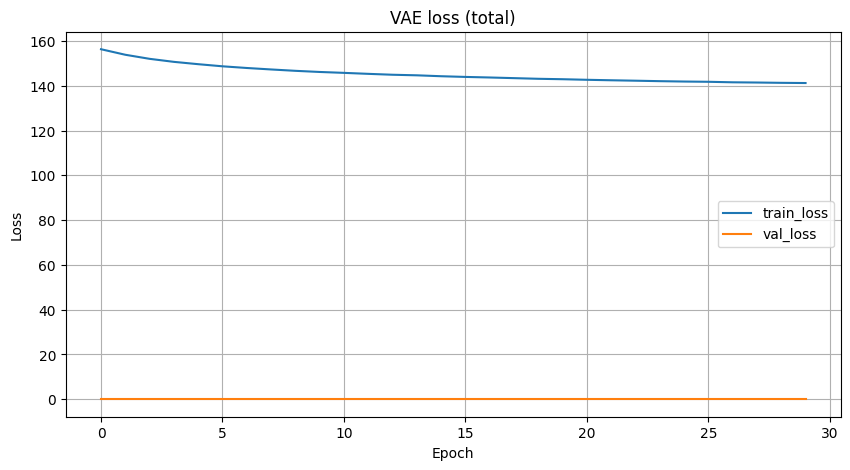

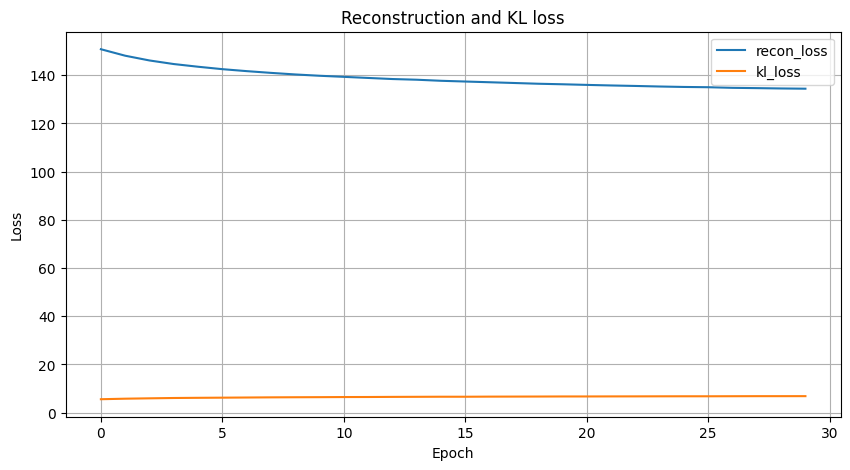

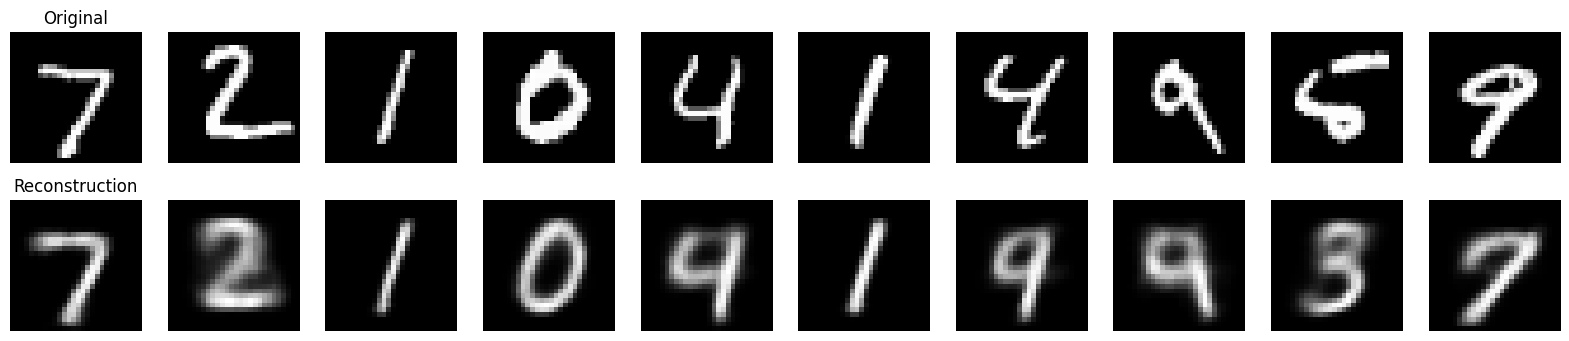

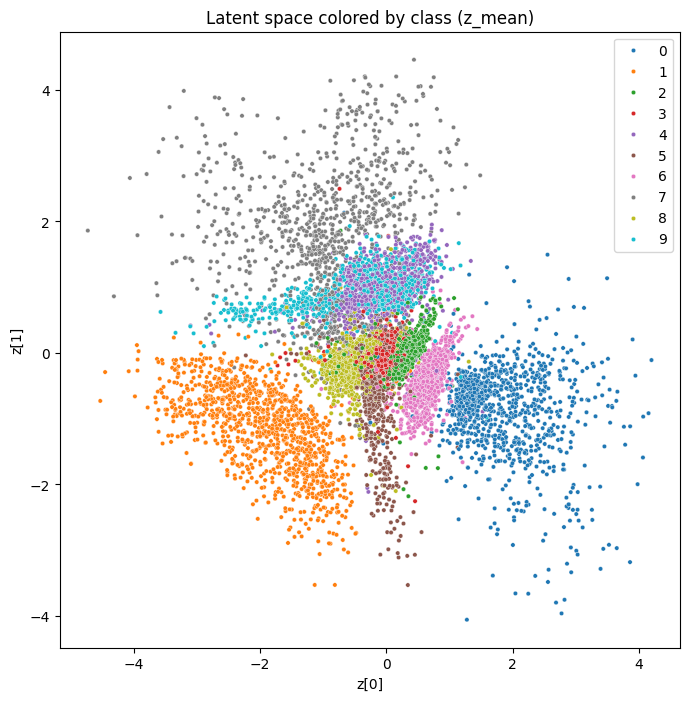

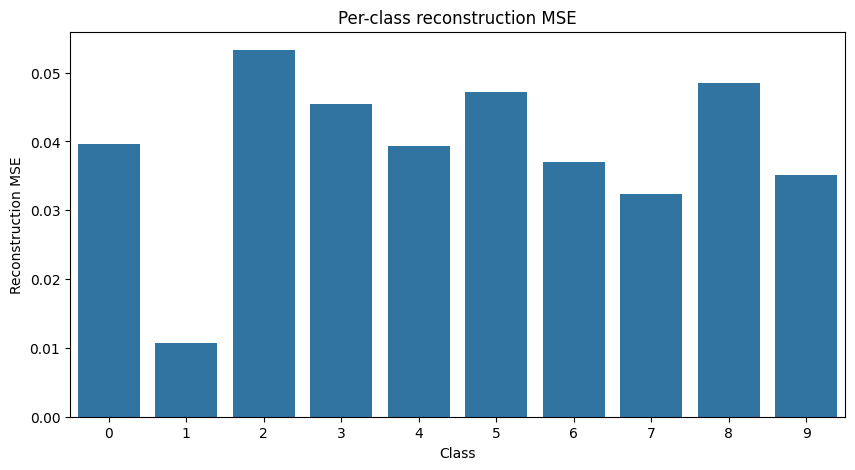

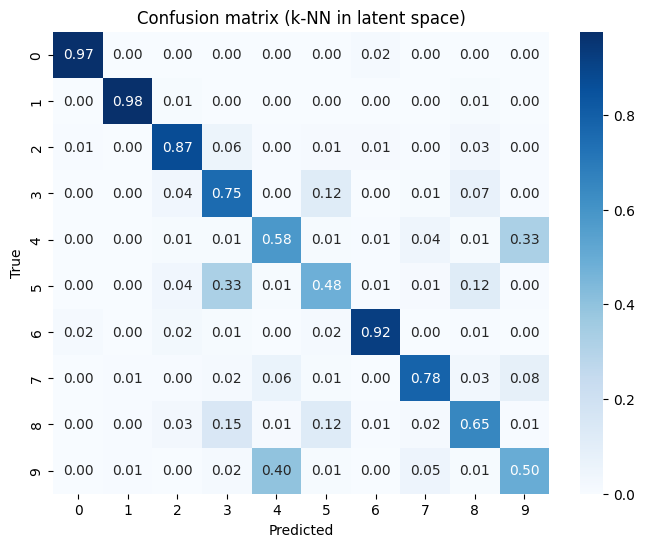

k-NN accuracy: 0.7547


In [ ]:
def plot_loss_curves(history):
    plt.figure(figsize=(10,5))
    # Total loss
    plt.plot(history.history['loss'], label='train_loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("VAE loss (total)")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Recon + KL
    plt.figure(figsize=(10,5))
    plt.plot(history.history['recon_loss'], label='recon_loss')
    plt.plot(history.history['kl_loss'], label='kl_loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Reconstruction and KL loss")
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_reconstructions(x_data, recon_data, n=10):
    plt.figure(figsize=(2*n,4))
    for i in range(n):
        # original
        ax = plt.subplot(2, n, i+1)
        plt.imshow(x_data[i].squeeze(), cmap='gray')
        plt.axis('off')
        if i == 0:
            ax.set_title("Original")
        # reconstruction
        ax = plt.subplot(2, n, n + i + 1)
        plt.imshow(recon_data[i].squeeze(), cmap='gray')
        plt.axis('off')
        if i == 0:
            ax.set_title("Reconstruction")
    plt.show()

def plot_latent_scatter(z_vis, labels, title="Latent space (2D)"):
    plt.figure(figsize=(8,8))
    palette = sns.color_palette("tab10", num_classes)
    sns.scatterplot(x=z_vis[:,0], y=z_vis[:,1], hue=labels, legend='full', palette=palette, s=10)
    plt.title(title)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

def plot_per_class_mse(per_class_mse):
    classes = list(per_class_mse.keys())
    vals = [per_class_mse[c] for c in classes]
    plt.figure(figsize=(10,5))
    sns.barplot(x=classes, y=vals)
    plt.xlabel("Class")
    plt.ylabel("Reconstruction MSE")
    plt.title("Per-class reconstruction MSE")
    plt.show()

def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion matrix (k-NN in latent space)")
    plt.show()

# Execute plots
plot_loss_curves(history)
plot_reconstructions(x_test, reconstructions, n=10)
if latent_dim == 2:
    plot_latent_scatter(z_vis, y_test, title="Latent space colored by class (z_mean)")
else:
    plot_latent_scatter(z_vis, y_test, title="t-SNE of latent means colored by class")
plot_per_class_mse(per_class_mse)
plot_confusion_matrix(cm_norm, classes=list(range(num_classes)))
print(f"k-NN accuracy: {knn_acc:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/

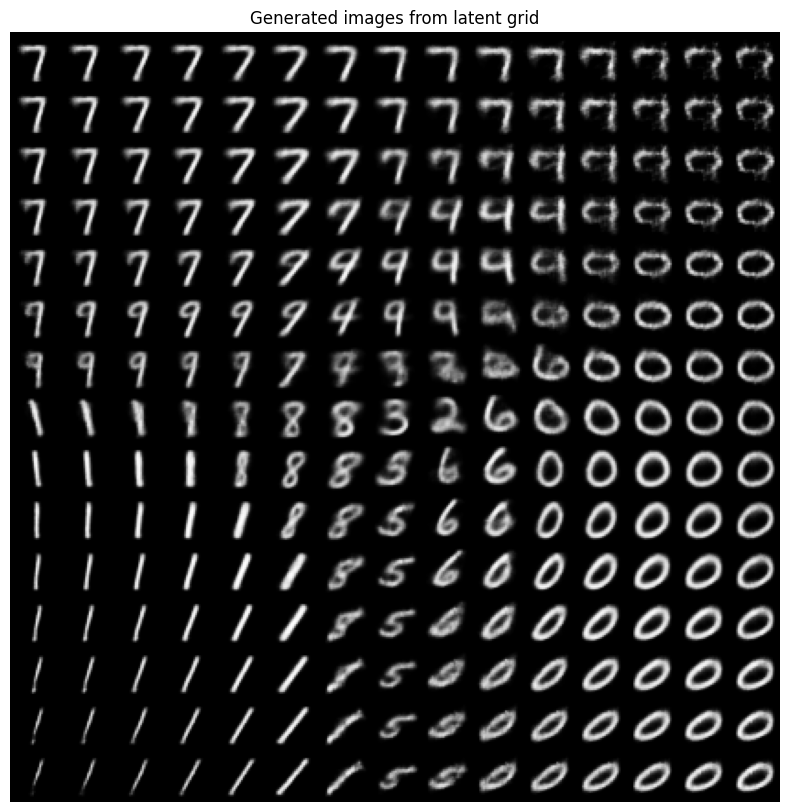

In [ ]:
def generate_grid(decoder, grid_size=15, scale=3.0):
    if latent_dim != 2:
        raise ValueError("Grid generation requires latent_dim == 2")
    # Create grid in latent space
    grid_x = np.linspace(-scale, scale, grid_size)
    grid_y = np.linspace(-scale, scale, grid_size)[::-1]
    figure = np.zeros((28 * grid_size, 28 * grid_size))
    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(28, 28)
            figure[i * 28: (i + 1) * 28,
                   j * 28: (j + 1) * 28] = digit
    plt.figure(figsize=(10,10))
    plt.imshow(figure, cmap='gray')
    plt.axis('off')
    plt.title("Generated images from latent grid")
    plt.show()

if latent_dim == 2:
    generate_grid(decoder, grid_size=15, scale=3.0)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


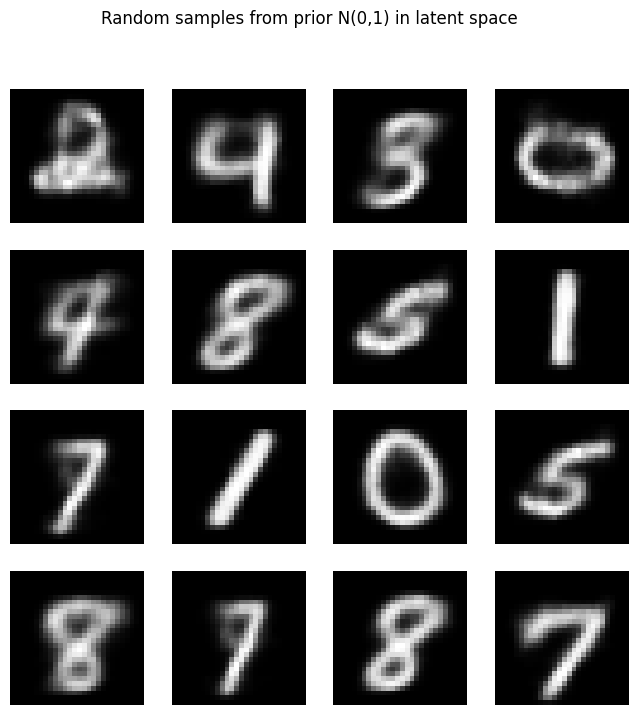

In [ ]:
def generate_random_samples(decoder, n=16):
    z_random = np.random.normal(size=(n, latent_dim))
    samples = decoder.predict(z_random)
    plt.figure(figsize=(8, 8))
    for i in range(n):
        ax = plt.subplot(int(np.sqrt(n)), int(np.sqrt(n)), i+1)
        plt.imshow(samples[i].squeeze(), cmap='gray')
        plt.axis('off')
    plt.suptitle("Random samples from prior N(0,1) in latent space")
    plt.show()

generate_random_samples(decoder, n=16)